<table style="width:100%;font-size:11pt">
        <tr style="width:100%;font-size:11pt">
            <td style="border: 1px #0098cd solid; background-color:#E6F4F9; color:#0098CD; width:35%"><center>Asignatura</center>
            </td>
            <td style="border: 1px #0098cd solid; background-color:#E6F4F9; color:#0098CD"><center>Datos del alumno</center>
            </td>
            <td style="border: 1px #0098cd solid; background-color:#E6F4F9; color:#0098CD; width:10%"><center>Fecha</center>
            </td>
        </tr>
        <tr style="width:100%;font-size:11pt">
            <td rowspan="2" style="border: 1px #0098cd solid"><center><b>Técnicas Multivaraintes y Machine Learning</b></center>
            </td>
            <td style="border: 1px #0098cd solid; text-align:left">Apellidos: Gómez del Hierro</td>
            <td rowspan="2" style="border: 1px #0098cd solid"><center>20/05/2024</center>
            </td>
        </tr>
        <tr>
            <td style="border: 1px #0098cd solid; text-align:left">Nombres: Gonzalo Miguel
            </td>
        </tr>
            <tr style="width:100%;font-size:11pt">
            <td style="border: 1px #0098cd solid; background-color:#E6F4F9; color:#0098CD"><center>Actividad</center>
            </td>
            <td colspan="2" style="border: 1px #0098cd solid; text-align:left">Laboratorio: Resolver un problema de regresión
            </td>
        </tr>    
</table>

### *Esta versión del notebook esta ajustada para el documento en pdf que hay que aportar.*

In [19]:
# importamos algunas librerías y funciones para usar durante el desarrollo de la práctica
import sklearn
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import copy as cp

A partir de mi NI (71204274) y según las reglas recogidas en el enunciado de la práctica, definimos la semilla siguiente. La definimos como un string para poder acceder a las posiciones de manera más cómoda. 
También, definimos los parámetros de entrada que necesita la función make_regression de sklearn tal y como se describe en el enunciado de la práctica.

In [20]:
semilla = '72224274' 

In [21]:
# definimos las variables de entrada para crear la colección de datos según se indica
n_samples = 200 + 10 * int(semilla[0])
n_features = 10 +  int(semilla[1]) + int(semilla[2])
n_informative = 10 + int(semilla[1])
noise = 10 * int(semilla[3])

In [22]:
# generamos la colección de datos
X, y = make_regression(n_samples=n_samples, n_features=n_features, n_informative=n_informative,
                      bias=2, noise=noise, random_state=int(semilla), shuffle=False)

De esta manera, hemos generado una muestra con 270 observaciones (n_samples) compuestas por 14 variables independientes (n_features) y una variable objetivo. De estas 14 variables independientes, 2 son redundantes (n_features - n_informative), como también veremos más adelante con un método paso a paso guiado por el p-valor. Como se puede ver en la documentación de la librería, el parámetro noise se corresponde con la desviación estándar del ruido que se aplica sobre la muestra perfectamente lineal, para romper dicha linealidad. Como también se puede ver en la documentación, el parámetro bias es la ordenada en el origen del modelo lineal del que se parte. Es decir, si el parámetro noise fuera 0, este bias sería la constante ($\beta_0$) en el modelo lineal $y = \beta_0 + \beta_1\cdot x_1 \cdot ... \cdot \beta_{14} \cdot x_{14}$. Se define el parámetro shuffle como False para que no se "barajen" observaciones y características.

A continuación, vamos a almacenar la información que sale de la función make_regression y vamos a recabar sus características haciendo uso de métodos propios de los DataFrames de Pandas.

In [23]:
# Generamos un dataset apropiado con la info que tenemos
# etiquetas para las n_features variables independientes + la variable independiente
columns = ['x{}'.format(i) for i in range(X.shape[1])]
columns.append('y')

In [24]:
# generamos un dataframe apropiado
df = pd.DataFrame(np.hstack((X,y[:, None])), columns=columns)

In [ ]:
# describimos nuestro conjunto de datos con algunas funciones útiles
df

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x0      270 non-null    float64
 1   x1      270 non-null    float64
 2   x2      270 non-null    float64
 3   x3      270 non-null    float64
 4   x4      270 non-null    float64
 5   x5      270 non-null    float64
 6   x6      270 non-null    float64
 7   x7      270 non-null    float64
 8   x8      270 non-null    float64
 9   x9      270 non-null    float64
 10  x10     270 non-null    float64
 11  x11     270 non-null    float64
 12  x12     270 non-null    float64
 13  x13     270 non-null    float64
 14  y       270 non-null    float64
dtypes: float64(15)
memory usage: 31.8 KB


In [27]:
df.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,y
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,-0.081585,-0.097058,-0.039994,-0.027497,-0.104199,0.050485,-0.020608,0.156459,-0.026023,-0.057981,0.104659,0.054468,-0.053897,-0.053776,3.890033
std,1.035451,0.961844,1.011112,0.991279,0.974281,0.941727,0.998258,1.027737,1.051168,0.983672,0.953814,1.000935,0.974444,0.994570,186.003767
min,-2.754765,-2.642654,-2.682709,-2.641308,-2.299527,-2.441561,-2.878151,-2.964314,-2.884744,-3.208742,-3.095005,-2.304660,-2.698280,-2.637598,-652.962806
25%,-0.768866,-0.814567,-0.768364,-0.729374,-0.786953,-0.559967,-0.658967,-0.505317,-0.722046,-0.705362,-0.554559,-0.711380,-0.676127,-0.702190,-114.400174
50%,-0.119491,-0.106750,-0.048220,-0.051611,-0.139248,0.034343,-0.044463,0.194328,-0.094226,-0.083917,0.089433,0.062546,-0.094599,-0.085843,2.808690
75%,0.614231,0.602314,0.633426,0.637455,0.529370,0.583760,0.687367,0.851522,0.724171,0.560182,0.663197,0.730935,0.576332,0.614925,132.729315
max,3.398219,2.014683,2.840378,2.590261,2.802959,2.419353,2.503547,2.910772,3.446197,2.778748,2.889454,3.034686,2.750551,3.182717,555.141179


Del describe anterior podemos observar que todas las features (variables independientes) $x_0,...x_{13}$ se distribuyen de maneras muy similar.

In [ ]:
df.head()

In [ ]:
df.tail()

Veamos la matriz de correlación de las variables independientes y la variable dependendiente, con el objetivo de tener una primera sensación de qué variable son más explicativas y también de si podemos tener variables redundantes.

In [ ]:
corr = df.corr(method='pearson')
# Mapa de calor sobre las ocrrelaciones entre variables
sns.heatmap(corr, cmap='coolwarm')

Como se ve en la figura, las variables independiente no están apenas correladas entre sí, y sí lo están con la variable independiente, aunque uno ya puede ver que las variables 4, 7, 8, 12 y 13 tienen un índice de correlación más bajo con la variable objetivo.

Podríamos dividir nuestro conjunto en simplemente las primeras 200 observaciones para el conjunto de entrenamiento y las restantes 70 para el conjunto de validación, pero por introducir herramientas establecidas en la industria, generemos nuestros conjuntos de manera aleatoria sobre la muestra.

Vamos a representar la variable objetivo en función de cada una de las variables independientes, como se pide en el enunciado, pero no resulta muy informativo.

In [ ]:
sns.pairplot(df, x_vars=columns[0:-1], y_vars=columns[-1])

In [32]:
# Dividimos nuestro conjunto en validación y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=70/270, random_state=40)
df_train = pd.DataFrame(np.hstack((X_train,y_train[:, None])), columns=columns)
df_test = pd.DataFrame(np.hstack((X_test,y_test[:, None])), columns=columns)

Construimos el modelo de regresión lineal múltiple usando la muestra de entrenamiento.

In [33]:
# Regresión lineal habitual por mínimos cuadrados
from sklearn.linear_model import LinearRegression
reg_ls = LinearRegression().fit(X_train, y_train)

In [49]:
# evaluamos la función obtenida en la muestra de variables independientes reservada para test
y_test_pred = reg_ls.predict(X_test)

In [35]:
from sklearn.metrics import mean_squared_error, r2_score
# Coeficientes del modelo
print("Coeficientes: \n", reg_ls.coef_, "\n", "Intercepto: \n", reg_ls.intercept_)
# Error cuadrático medio sobre la muestra de test
mean_error_lsm = cp.copy(mean_squared_error(y_test, y_test_pred))
print("Error cuadrático medio: %.2f" % mean_error_lsm)
# Coeficiente de determinación 1 significa predicción perfecta
r2_lsm = cp.copy(r2_score(y_test, y_test_pred))
print("Coeficiente de determinación R2: %.4f" % r2_lsm)

Coeficientes: 
 [43.94602382 22.46183943 29.83640725 92.26844468 10.59352384 71.49254563
 97.85547196  3.45748611  9.52834508 15.67491137 72.3429387  73.63585407
  0.68818835 -0.58378327] 
 Intercepto: 
 2.6948483674190102
Error cuadrático medio: 464.45
Coeficiente de determinación R2: 0.9854


La predicción es muy buena.
Si atendemos a los coeficientes obtenidos para la regresión es claro que las variables 12 y 13 tienen un peso despreciable en el cáclulo de $y$, y por tanto podremos eliminarlas sin perder capacidad explicativa de la variable objetivo.

Podemos repetir la operación anterior excluyendo estas variables de una en una siguiendo algún criterio. También podríamos llevar a cabo, por ejemplo, un análisis de componentes principales y quedarnos con las componentes que necesitásemos para explicar la mayor parte de la varianza de la variable objetivo.

Solo en esta ocasión, sin falta de generalidad para las posteriores regresiones, probamos la normalidad de los residuos sobre la muestra de test.

In [36]:
# obtener residuos sobre la muestra de entrenamiento
y_pred = reg_ls.predict(X_train)
residuos = y_train - y_pred
y_resta = residuos ** 2
import scipy.stats as stats
sh_result = stats.shapiro(residuos)

# dar formato a la salida
print("Test Shapiro-Wilk, p.valor: %5.5f" %(sh_result.pvalue))
print("Como p.valor > 0.05, no se rechaza la hipótesis nula y se da normalidad en los residuos.")

Test Shapiro-Wilk, p.valor: 0.84126
Como p.valor > 0.05, no se rechaza la hipótesis nula y se da normalidad en los residuos.


In [37]:
import statsmodels.api as sm
import statsmodels.stats.api as sms
X2 = sm.add_constant(df_train[columns[0:-1]])
est = sm.OLS(y_train,X2) # ordinary least squares method for regression
est2 = est.fit()
bp1 = sms.het_breuschpagan(resid = est2.resid, exog_het = est2.model.exog)[1]
print("El resultado del test Breusch-Pagan es: p.valor = %5.3f"%(bp1))
print("Como p.valor > 0.05, no se rechaza la hipótesis nula y se da homocedasticidad.")

El resultado del test Breusch-Pagan es: p.valor = 0.396
Como p.valor > 0.05, no se rechaza la hipótesis nula y se da homocedasticidad.


In [38]:
# calcular ICbeta1

# calcular numerador sb1^2
s2 = sum(y_resta)/(len(y_train)-2)

# calcular denominador sb1^2
den = np.var(X) * len(X)
# calcular sb1
sb1 = (s2/den) ** 0.5
amplitud = 1.96 * sb1
print("El IC al 0.95 de b1 es:", reg_ls.coef_, "+/-", amplitud)
print("El intervalo de confianza contiene al 0 para los dos últimos coeficientes, luego, las dos últimas variables (x12 y x13) no son significativas.")

El IC al 0.95 de b1 es: [43.94602382 22.46183943 29.83640725 92.26844468 10.59352384 71.49254563
 97.85547196  3.45748611  9.52834508 15.67491137 72.3429387  73.63585407
  0.68818835 -0.58378327] +/- 2.349341987407838
El intervalo de confianza contiene al 0 para los dos últimos coeficientes, luego, las dos últimas variables (x12 y x13) no son significativas.


In [39]:
# Hagamos algo de análisis estadístico extra sobre la regresión lineal que se obtiene meidante la librería statsmodel
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1216.
Date:                Sat, 18 May 2024   Prob (F-statistic):          8.28e-174
Time:                        14:26:02   Log-Likelihood:                -877.72
No. Observations:                 200   AIC:                             1785.
Df Residuals:                     185   BIC:                             1835.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6948      1.506      1.789      0.0

Nótese que para este análisis más exhaustivo hemos tenido que volver a calcular los parámetros de la regresión para aprovechar la infraestructura que ofrece statsmodels (cuando ya habíamos empleado la clase LinearRegression de sklearn). Además este análisis es como "matar moscas a cañonazos", puesto que por el momento no nos vamos a fijar mucho más que en los $R^2$, los coeficientes y los p-valores.

Atendiendo a la columna P>|t| (mayor valor implica menor significatividad estadística) de nuevo podemos observarque las variables $x_{13}$ ($x_{12}$ en el df) y $x_{14}$ ($x_{13}$ en el df) son las candidatas de no ser significativas.

Con un algoritmo paso a paso, guiados por el p-valor y con una condición de parada basada en el rango en que se encuentren todos los p-valores, vamos a eliminar las variable con mayor p-valor, rehacer la regresión, calcular los p-valores y rehacer la operación hasta que se cumpla la condición de salida.

In [40]:
tol = 1
# comenzamos considerando todas las variables
x_columns = columns[0:-1]
idx = np.argwhere(est2.pvalues == max(est2.pvalues))[0][0]
iter = 0
removed_var = []
while tol > 1e-2 and idx != 0:    
    iter += 1
    removed_var.append(x_columns[idx-1])
    x_columns.remove(x_columns[idx-1])    
    X2 = sm.add_constant(df_train[x_columns])
    est_aux = sm.OLS(y_train,X2).fit()
    idx = np.argwhere(est_aux.pvalues == max(est_aux.pvalues))[0][0]
    tol = abs(max(est_aux.pvalues) - min(est_aux.pvalues))
print("Variables eliminadas:", removed_var)
print("Variables significativas:", x_columns)
print(est_aux.summary())    

Variables eliminadas: ['x13', 'x12']
Variables significativas: ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     1430.
Date:                Sat, 18 May 2024   Prob (F-statistic):          7.19e-177
Time:                        14:26:02   Log-Likelihood:                -877.95
No. Observations:                 200   AIC:                             1782.
Df Residuals:                     187   BIC:                             1825.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      

Como ya habíamos anticipado a través de varios indicadores, las variables no significativas eran las dos últimas, y al eliminarlas no hemos perdido bondad en el ajuste.

A continuación, sobre las variables ya determinadas como significativas: ridge, lasso y red elástica, a través de sklearn.

La regresión de Ridge es una regresión por mínimos cuadrados con una penalización $\mathcal{L}^2$, es decir, una penalización proporcional a las normas 2, pesada por el parámetro $\alpha$.

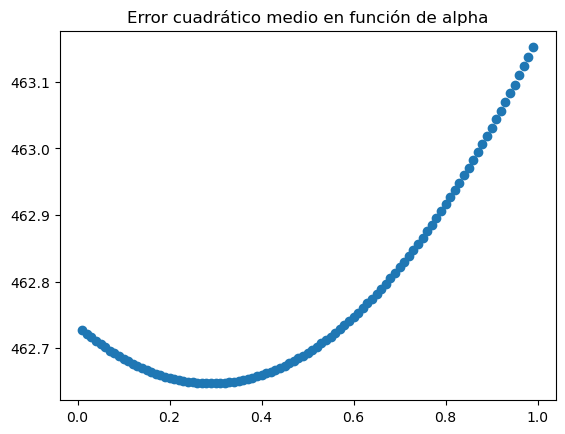

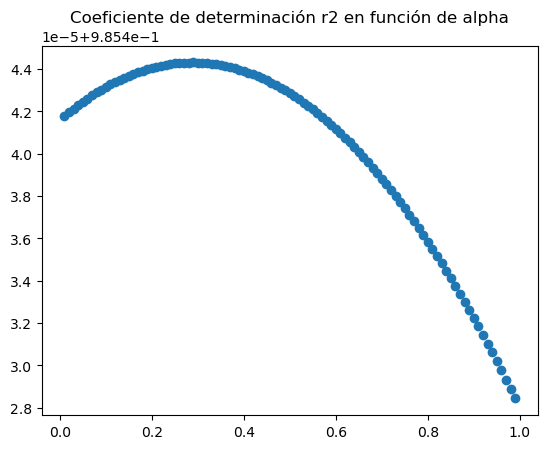

In [41]:
"""Ridge linear regression depending on alpha"""
from sklearn.linear_model import Ridge
def ridge_test(alpha_list):
    ridge_mean_error = []
    ridge_r2 = []
    for a in alpha_list:
        Ridge_aux = Ridge(alpha=a).fit(df_train[x_columns], y_train)
        y_pred = Ridge_aux.predict(df_test[x_columns])
        ridge_mean_error.append(mean_squared_error(y_test,y_pred))
        ridge_r2.append(r2_score(y_test,y_pred))    
    f, ax = plt.subplots()
    ax.scatter(alpha_list, ridge_mean_error)
    ax.set_title('Error cuadrático medio en función de alpha')
    plt.show()
    f, ax = plt.subplots()
    ax.scatter(alpha_list, ridge_r2)
    ax.set_title('Coeficiente de determinación r2 en función de alpha')
    plt.show()
    return ridge_mean_error, ridge_r2
mean_error, r2_values = ridge_test(np.arange(0.01,1,0.01))

De las gráficas anteriores se observa un mínimo en cuanto a error y máximo en cuanto a $R^2$ en torno a $\alpha=0.3$, pero podemos determinarlo de manera numérica (lógicamente, el valor de alpha que minimiza el error cuadrático medio también maximiza el coeficiente de determinación, así que sería suficiente con hallar el extremo de la curva $R^2(\alpha)$ para obtener un valor óptimo, al menos localmente).

In [ ]:
# hagamos zoom en torno a la zona óptima
mean_error_ridge, r2_values_ridge = ridge_test(np.arange(0.27,0.30,0.001))

In [43]:
idx_optim = np.argwhere(r2_values_ridge == max(r2_values_ridge))[0][0]
ridge_r2_optim = cp.copy(r2_values[idx_optim])
ridge_mean_error_optim = cp.copy(mean_error[idx_optim])
print("El valor alpha óptimo es: {:.4f}".format((np.arange(0.27,0.30,0.001))[idx_optim]))
print("El R2 para la regresión de Ridge y alpha óptimo es: {:.7f}".format(r2_values[idx_optim]))
print("El error cuadrático medio para la regresión de Ridge y alpha óptimo es: {:.2f}".format(mean_error[idx_optim]))

El valor alpha óptimo es: 0.2880
El R2 para la regresión de Ridge y alpha óptimo es: 0.9854440
El error cuadrático medio para la regresión de Ridge y alpha óptimo es: 462.66


Pasemos a hacer un tratamiento análogo pero con la regresión de Lasso. La regresión de Lasso es una regresión por mínimos cuadrados con una penalización $\mathcal{L}^1$, es decir, una penalización proporcional a las normas 1, pesada por el parámetro $\alpha$. Como vemos a continuación, esta penalización no parece ser una buena opción para nuestra muestra, pues nuestro óptimo en cuanto a bondad del ajuste lo encontramos para el menor valor de $\alpha$ considerado.

In [ ]:
"""Lasso linear regression depending on alpha"""
from sklearn.linear_model import Lasso
def lasso_test(alpha_list):
    lasso_mean_error = []
    lasso_r2 = []
    for a in alpha_list:
        lasso_aux = Lasso(alpha=a).fit(df_train[x_columns], y_train)
        y_pred = lasso_aux.predict(df_test[x_columns])
        lasso_mean_error.append(mean_squared_error(y_test,y_pred))
        lasso_r2.append(r2_score(y_test,y_pred))    
    f, ax = plt.subplots()
    ax.scatter(alpha_list, lasso_mean_error)
    ax.set_title('Error cuadrático medio en función de alpha')
    plt.show()
    f, ax = plt.subplots()
    ax.scatter(alpha_list, lasso_r2)
    ax.set_title('Coeficiente de determinación r2 en función de alpha')
    plt.show()
    return lasso_mean_error, lasso_r2
mean_error_lasso, r2_values_lasso = lasso_test(np.arange(0.00001,1,0.001))

In [45]:
idx_optim = np.argwhere(r2_values_lasso == max(r2_values_lasso))[0][0]
lasso_r2_optim = cp.copy(r2_values_lasso[idx_optim])
lassos_mean_error_optim = cp.copy(mean_error_lasso[idx_optim])
print("El valor alpha óptimo es: {:.5f}".format((np.arange(0.00001,1,0.001))[idx_optim]))
print("El R2 para la regresión de Lasso y alpha óptimo es: {:.7f}".format(r2_values_lasso[idx_optim]))
print("El error cuadrático medio para la regresión de Lasso y alpha óptimo es: {:.2f}".format(mean_error_lasso[idx_optim]))

El valor alpha óptimo es: 0.00001
El R2 para la regresión de Lasso y alpha óptimo es: 0.9854416
El error cuadrático medio para la regresión de Lasso y alpha óptimo es: 462.73


Ahora hagamos lo mismo pero con el método de la red elástica, donde en vez de un parámetro manejamos dos (r y $\alpha$). Vamos a hacer una función similar a las anteriores, pero que tomará como entrada dos listas en vez de una. En la documentación referida a esta clase en sklearn, se específica que el parámetro $r$ debe estar entre 0 y 1, y que para $r=1$ recuperaríamos el modelo de Lasso.

En este caso, atendiendo a la documentación de sklearn, donde podemos encontrar lo siguiente:

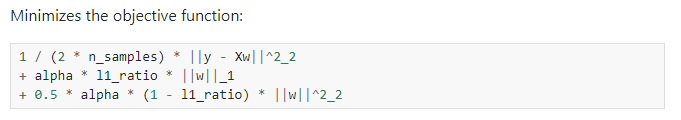

Atendiendo a los valores óptimos que encontramos, la penalización en norma 2 será menos significativa que la penalización en norma 1, lo que concuerda con que en la regresión de Lasso obtuviéramos un $\alpha$ tan pequeño, y es que parece que no es el mejor camino para ajustar nuestra muestra.

In [ ]:
"""Elastic Net linear regression depending on alpha and r"""
from sklearn.linear_model import ElasticNet
from matplotlib import cm
def elastic_net_test(alpha_list, r_list):
    a, r = np.meshgrid(alpha_list,r_list)
    en_mean_error = np.ones_like(a)
    en_r2 = np.ones_like(en_mean_error)  
    for j in range(len(r_list)):
        for i in range(len(alpha_list)):
            en_aux = ElasticNet(alpha=alpha_list[i], l1_ratio=r_list[j]).fit(df_train[x_columns], y_train)
            y_pred = en_aux.predict(df_test[x_columns])
            en_mean_error[j,i] = mean_squared_error(y_test,y_pred)
            en_r2[j][i] = r2_score(y_test,y_pred)
    f1, ax1 = plt.subplots(subplot_kw={"projection": "3d"})
    surf1 = ax1.plot_surface(a, r, en_mean_error, linewidth=0,cmap=cm.coolwarm, antialiased=False)
    ax1.set_xlabel('alpha')
    ax1.set_ylabel('r')
    ax1.set_title('Error cuadrático medio')
    f1.colorbar(surf1, shrink=0.5, aspect=5)
    plt.show()
    f2, ax2 = plt.subplots(subplot_kw={"projection": "3d"})
    surf2 = ax2.plot_surface(a, r, en_r2, linewidth=0,cmap=cm.coolwarm, antialiased=False)
    ax2.set_xlabel('alpha')
    ax2.set_ylabel('r')
    ax2.set_title('R2')
    f2.colorbar(surf2, shrink=0.5, aspect=5)
    plt.show()
    return en_mean_error, en_r2
mean_error_en, r2_values_en = elastic_net_test(np.arange(0.01,2,0.01), np.arange(0.01,1,0.01))

In [47]:
idx_optim = np.argwhere(r2_values_en == np.max(r2_values_en))
idx_optim = idx_optim[0]
en_r2_optim = cp.copy(r2_values_en[idx_optim[0]][idx_optim[1]])
en_mean_error_optim = cp.copy(mean_error_en[idx_optim[0]][idx_optim[1]])
print("El valor alpha óptimo es: {:.5f}".format((np.arange(0.1,10,0.1))[idx_optim[1]]))
print("El valor r óptimo es: {:.5f}".format((np.arange(0.01,1,0.01))[idx_optim[0]]))
print("El R2 para alpha y r óptimos: {:.7f}".format(r2_values_en[idx_optim[0]][idx_optim[1]]))
print("El error cuadrático medio para alpha y r óptimos: {:.2f}".format(mean_error_en[idx_optim[0]][idx_optim[1]]))

El valor alpha óptimo es: 0.10000
El valor r óptimo es: 0.84000
El R2 para alpha y r óptimos: 0.9854382
El error cuadrático medio para alpha y r óptimos: 462.84


Por último, comparemos los $R^2$ y los errores cuadráticos medios obtenidos en el mejor ajuste por cada uno de los métodos. Nótese que estos indicadores se han obtenido a partir de la comparación de la predicción y los valores reales en la muestra de test.

In [48]:
list_reg_method = ['LS Basic Method', 'Ridge', 'Lasso', 'Elastic Net']
r2_list = [r2_lsm, ridge_r2_optim, lasso_r2_optim, en_r2_optim]
mean_error_list = [mean_error_lsm, ridge_mean_error_optim, lassos_mean_error_optim, en_mean_error_optim]
data_reg = {'Method' : list_reg_method, 'R2': r2_list, 'MSE': mean_error_list}
df_reg = pd.DataFrame(data=data_reg)
print(df_reg)

            Method        R2         MSE
0  LS Basic Method  0.985388  464.446828
1            Ridge  0.985444  462.657176
2            Lasso  0.985442  462.733718
3      Elastic Net  0.985438  462.840047


Con el nivel de precisión con el que se ha llevado a cabo el desarrollo, podemos afirmar que ciertamente los métodos de Ridge, Lasso y red elástica mejoran a la regresión por mínimos cuadrados básica, pero no exhibiría conclusiones muy fuertes sobre la posterior comparación entre ellos. Sí que, guiados por las resultados obtenidos, podemos afirmar que el camino de Ridge (penalización en norma 1) es algo más apropiada que la penalización en norma 2 que se emplea en Lasso y también en la cuerda elástica, pero teniendo en cuenta la similitud entre los resultados y los grids de parámetros sobre los que hemos evaluado las regresiones, no afirmaría que red elástica sea peor que Lasso (aunque extrictamente el resultado obtenido sí lo sea).

Bibliografía:
- Trevor, et al. The elements of statistical learning: data mining, inference, and prediction. New York: springer, 2009.
- https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge
- https://www.statsmodels.org/dev/generated/statsmodels.formula.api.ols.html#statsmodels.formula.api.ols